In [48]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy as stats
import seaborn as sns

import statsmodels.api as sm
from sklearn.linear_model import HuberRegressor, LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split, learning_curve
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

plt.rcParams['figure.figsize'] = (10,5)

In [37]:
# import datasets
from sklearn.datasets import load_boston
boston_dataset = load_boston()
boston = pd.DataFrame(boston_dataset.data, columns=boston_dataset.feature_names)
boston['MEDV'] = boston_dataset.target

In [39]:
print(boston_dataset.DESCR)

.. _boston_dataset:

Boston house prices dataset
---------------------------

**Data Set Characteristics:**  

    :Number of Instances: 506 

    :Number of Attributes: 13 numeric/categorical predictive. Median Value (attribute 14) is usually the target.

    :Attribute Information (in order):
        - CRIM     per capita crime rate by town
        - ZN       proportion of residential land zoned for lots over 25,000 sq.ft.
        - INDUS    proportion of non-retail business acres per town
        - CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
        - NOX      nitric oxides concentration (parts per 10 million)
        - RM       average number of rooms per dwelling
        - AGE      proportion of owner-occupied units built prior to 1940
        - DIS      weighted distances to five Boston employment centres
        - RAD      index of accessibility to radial highways
        - TAX      full-value property-tax rate per $10,000
        - PTRATIO  pu

## Explore the data

In [12]:
boston.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2


In [13]:
boston.shape

(506, 14)

In [19]:
boston.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 14 columns):
CRIM       506 non-null float64
ZN         506 non-null float64
INDUS      506 non-null float64
CHAS       506 non-null float64
NOX        506 non-null float64
RM         506 non-null float64
AGE        506 non-null float64
DIS        506 non-null float64
RAD        506 non-null float64
TAX        506 non-null float64
PTRATIO    506 non-null float64
B          506 non-null float64
LSTAT      506 non-null float64
MEDV       506 non-null float64
dtypes: float64(14)
memory usage: 55.4 KB


count    506.000000
mean      22.532806
std        9.197104
min        5.000000
25%       17.025000
50%       21.200000
75%       25.000000
max       50.000000
Name: MEDV, dtype: float64

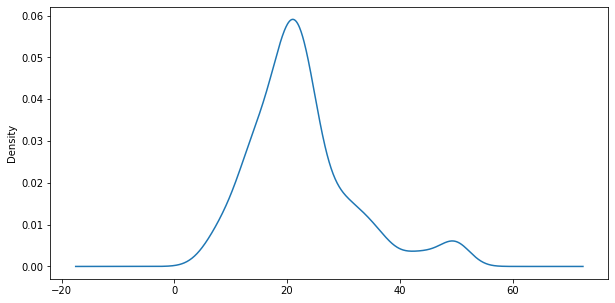

In [14]:
# plot distrubtion of target
boston['MEDV'].plot(kind='kde');
boston['MEDV'].skew()
boston['MEDV'].describe()

In [15]:
# distribution of features
boston.iloc[:,:-1].describe()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
count,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000
mean,3.613524,11.363636,11.136779,0.069170,0.554695,6.284634,68.574901,3.795043,9.549407,408.237154,18.455534,356.674032,12.653063
std,8.601545,23.322453,6.860353,0.253994,0.115878,0.702617,28.148861,2.105710,8.707259,168.537116,2.164946,91.294864,7.141062
min,0.006320,0.000000,0.460000,0.000000,0.385000,3.561000,2.900000,1.129600,1.000000,187.000000,12.600000,0.320000,1.730000
25%,0.082045,0.000000,5.190000,0.000000,0.449000,5.885500,45.025000,2.100175,4.000000,279.000000,17.400000,375.377500,6.950000
50%,0.256510,0.000000,9.690000,0.000000,0.538000,6.208500,77.500000,3.207450,5.000000,330.000000,19.050000,391.440000,11.360000
75%,3.677083,12.500000,18.100000,0.000000,0.624000,6.623500,94.075000,5.188425,24.000000,666.000000,20.200000,396.225000,16.955000
max,88.976200,100.000000,27.740000,1.000000,0.871000,8.780000,100.000000,12.126500,24.000000,711.000000,22.000000,396.900000,37.970000


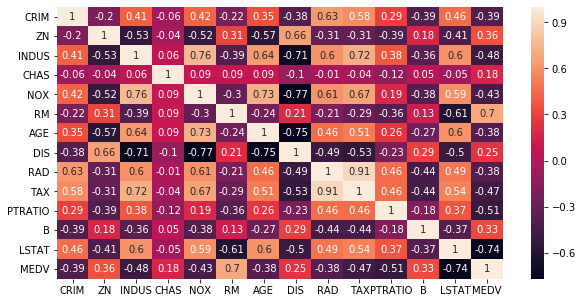

In [16]:
# correlation matrix
correlation_matrix = boston.corr().round(2)
sns.heatmap(data=correlation_matrix, annot=True);

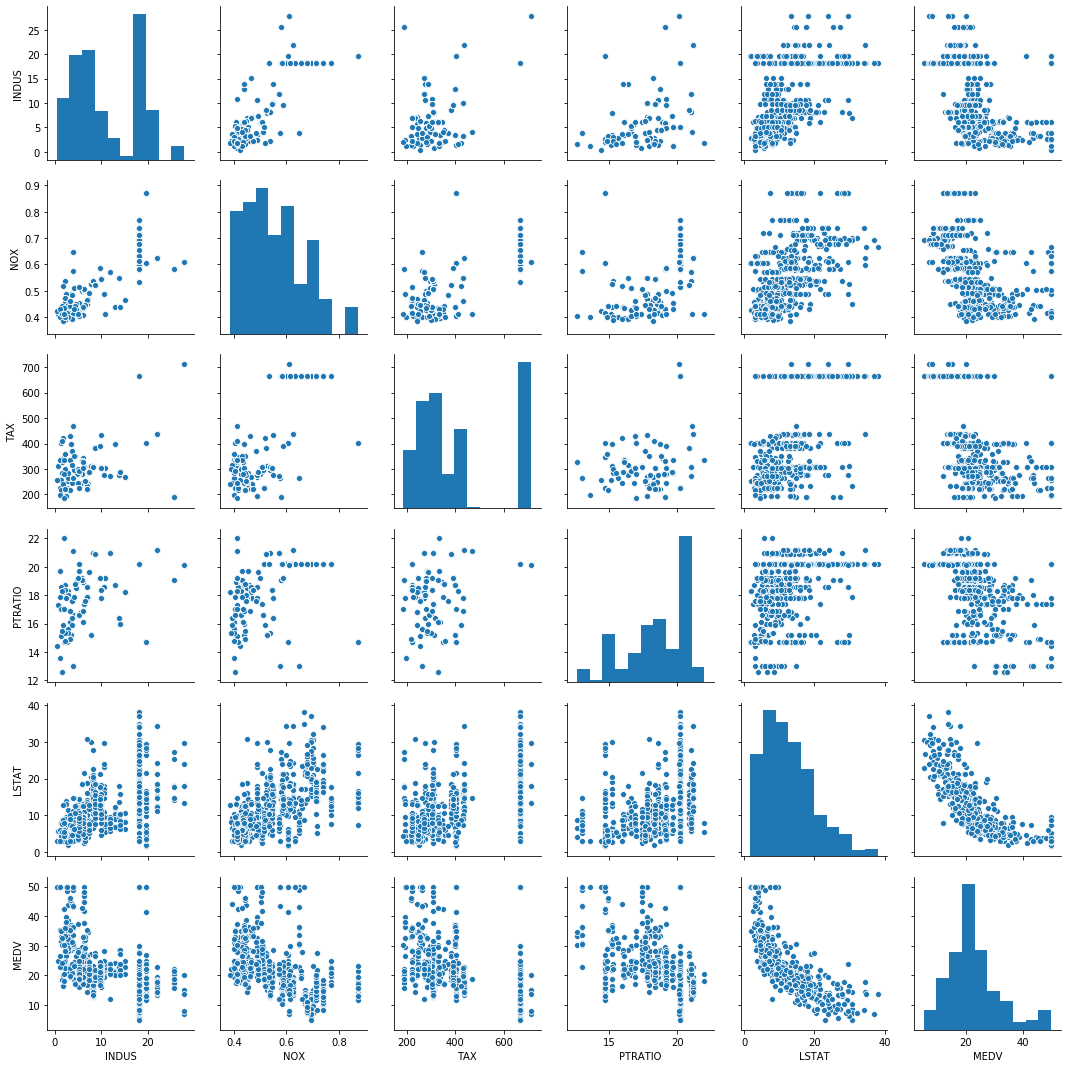

In [17]:
# pairwise plot for selected features
sns.pairplot(boston[['INDUS','NOX','TAX','PTRATIO','LSTAT','MEDV']]);

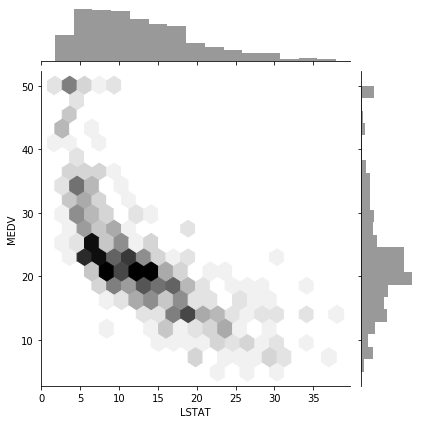

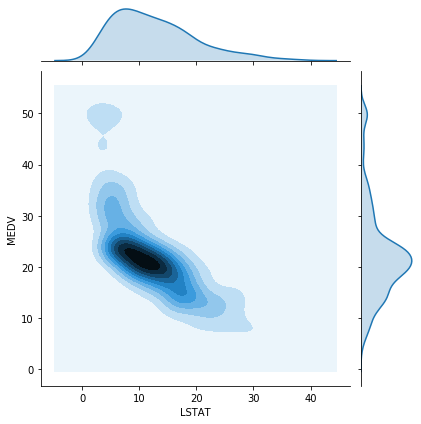

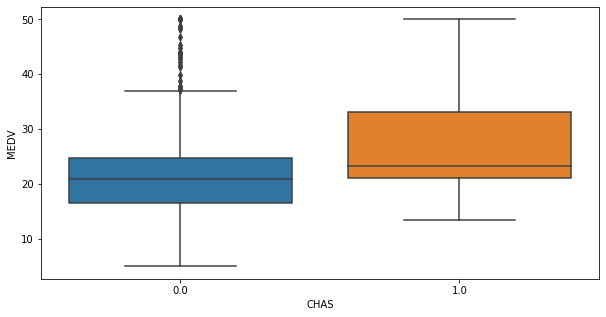

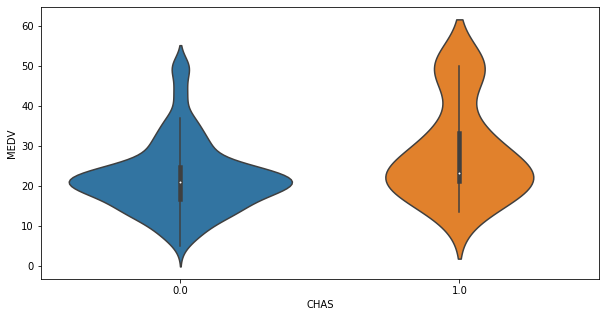

In [43]:
# other bivariate plots
sns.jointplot(x='LSTAT', y='MEDV', kind="hex", color="k", data=boston);
sns.jointplot(x="LSTAT", y="MEDV", data=boston, kind="kde");
plt.show()
sns.boxplot(x="CHAS", y="MEDV", data=boston);
plt.show()
sns.violinplot(x="CHAS", y="MEDV", data=boston);

## Define Training and Test Validation Sets

In [55]:
# subset X (features) and y (target)
X = boston[boston_dataset.feature_names]
y = boston['MEDV']

In [56]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 52)

## Ridge

## OLS - Statsmodels</br>
Nicer output statistical inference and interpretation

In [74]:
# fit model (subset X, user correlation matrix and plots as guide)
features = ['INDUS','NOX','TAX','PTRATIO','LSTAT']
model = sm.OLS(y_train, X_train[features])
results = model.fit()

In [75]:
print(results.summary())

OLS Regression Results                                
Dep. Variable:                   MEDV   R-squared (uncentered):                   0.908
Model:                            OLS   Adj. R-squared (uncentered):              0.907
Method:                 Least Squares   F-statistic:                              788.0
Date:                Thu, 07 May 2020   Prob (F-statistic):                   3.18e-204
Time:                        10:16:54   Log-Likelihood:                         -1378.7
No. Observations:                 404   AIC:                                      2767.
Df Residuals:                     399   BIC:                                      2787.
Df Model:                           5                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------

In [79]:
y_predict = results.predict(X_train[features])

## Residual Plots

In [ ]:
residuals = y_train - y_predict

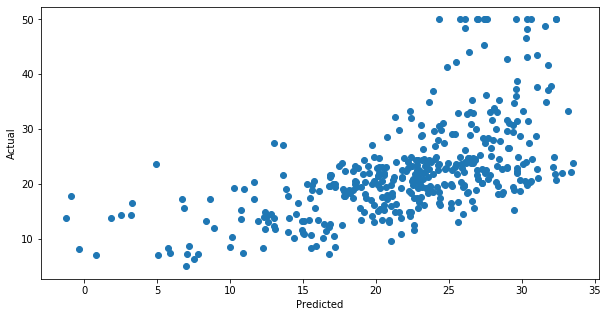

In [106]:
plt.scatter(y_predict, y_train)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

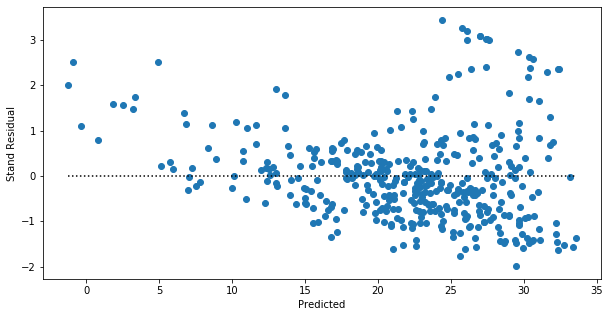

In [104]:
scaler = StandardScaler()
std_residuals = scaler.fit_transform(residuals.values.reshape(-1,1))
plt.scatter(y_predict, std_residuals)
plt.xlabel('Predicted')
plt.ylabel('Stand Residual')
plt.hlines(0, y_predict.min(), y_predict.max(), linestyles='dotted')
plt.show()

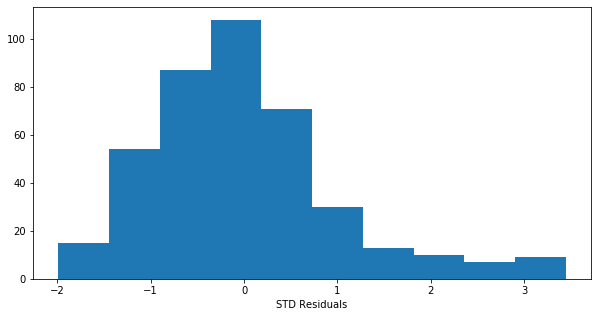

In [115]:
plt.hist(std_residuals)
plt.xlabel('STD Residuals')
plt.show()